# FC_GAN

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

In [ ]:

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # Importing Datasets
# (28*28*1) - Here 1 represents the channels 1-Greyscale, 3-RGB.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshaping into (No. Of Images,28,28,1) and converting to flaot32
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
noise_dim = 100
EPOCHS = 50
img_rows, img_cols, channels = 28, 28, 1
#num_example_to_generate = 16
seed = tf.random.normal([1, noise_dim])

In [ ]:
def fcgan_generator_model():
  generator = tf.keras.Sequential()

  generator.add(layers.Dense(256, input_shape = (noise_dim,)))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU(0.2))

  generator.add(layers.Dense(512))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU(0.2))

  generator.add(layers.Dense(1024))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU(0.2))

  generator.add(layers.Dense(img_rows*img_cols*channels, activation = 'tanh'))
  generator.add(layers.Reshape((img_rows, img_cols, channels)))
  return generator

In [ ]:
def fcgan_discriminator_model():
  discriminator = tf.keras.Sequential()

  discriminator.add(layers.Flatten(input_shape=(img_rows, img_cols, channels)))

  discriminator.add(layers.Dense(256))
  discriminator.add(layers.BatchNormalization())
  discriminator.add(layers.LeakyReLU(0.2))

  discriminator.add(layers.Dense(128))
  discriminator.add(layers.BatchNormalization())
  discriminator.add(layers.LeakyReLU(0.2))

  discriminator.add(layers.Dense(64))
  discriminator.add(layers.BatchNormalization())
  discriminator.add(layers.LeakyReLU(0.2))

  discriminator.add(layers.Dense(1, activation = 'sigmoid'))

  return discriminator

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [ ]:
generator = fcgan_generator_model()
discriminator = fcgan_discriminator_model()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


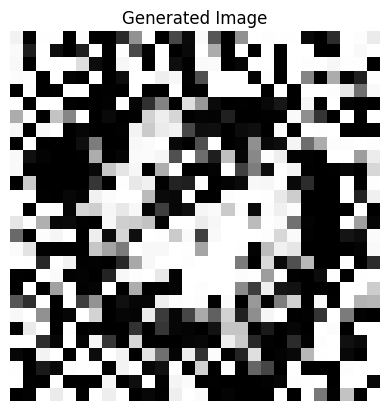

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate noise
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("Generated Image")
plt.axis("off")
plt.show()


In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
#later
generated_images = []

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  generated_images.append(predictions[0, :, :, 0].numpy() * 127.5 + 127.5)

In [ ]:
def display_in_grid(images, cols, rows):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2,rows * 2))
    for i, img in enumerate(axs.flat):
        img.imshow(images[i], cmap='gray')
        img.axis('off')
        img.set_title(f"Epoch {i+1}", fontsize=8)
    plt.show()

In [ ]:
def train(dataset, epochs, cols, rows):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator, epoch+1, seed)
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  display_in_grid(generated_images, cols, rows)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 20.654122829437256 sec
Time for epoch 2 is 1.9550261497497559 sec
Time for epoch 3 is 2.1217880249023438 sec
Time for epoch 4 is 2.4969680309295654 sec
Time for epoch 5 is 2.067049980163574 sec
Time for epoch 6 is 1.8970539569854736 sec
Time for epoch 7 is 1.9191687107086182 sec
Time for epoch 8 is 2.5548248291015625 sec
Time for epoch 9 is 2.3355014324188232 sec
Time for epoch 10 is 2.67918062210083 sec
Time for epoch 11 is 2.1412429809570312 sec
Time for epoch 12 is 1.9462378025054932 sec
Time for epoch 13 is 2.4756526947021484 sec
Time for epoch 14 is 2.159376382827759 sec
Time for epoch 15 is 2.818579912185669 sec
Time for epoch 16 is 2.553069591522217 sec
Time for epoch 17 is 1.917165756225586 sec
Time for epoch 18 is 1.9009478092193604 sec
Time for epoch 19 is 1.9212977886199951 sec
Time for epoch 20 is 2.305314302444458 sec
Time for epoch 21 is 2.455744504928589 sec
Time for epoch 22 is 1.9279658794403076 sec
Time for epoch 23 is 1.9178733825683594 sec
Time f

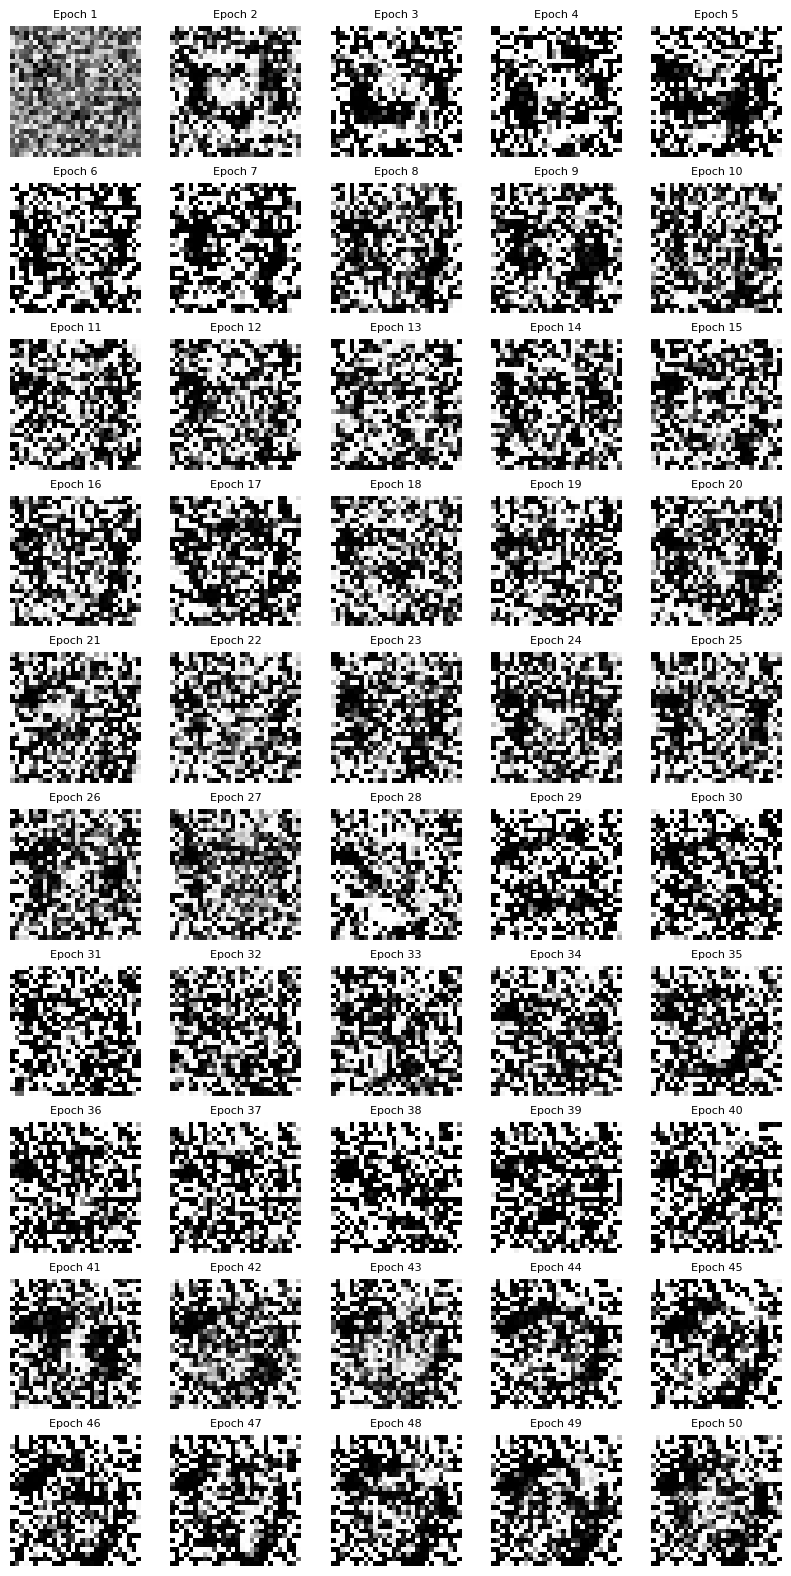

In [ ]:
train(train_dataset, EPOCHS, 5, 10)

#DC_GAN

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # Importing Datasets
# (28*28*1) - Here 1 represents the channels 1-Greyscale, 3-RGB.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshaping into (No. Of Images,28,28,1) and converting to flaot32
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
noise_dim = 100
EPOCHS = 50
img_rows, img_cols, channels = 28, 28, 1
#num_example_to_generate = 16
seed = tf.random.normal([1, noise_dim])

In [ ]:
def dcgan_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [ ]:
def dcgan_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
generator = dcgan_generator_model()
discriminator = dcgan_discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

dcgan_checkpoint_dir = './training_checkpoints2'
checkpoint_prefix = os.path.join(dcgan_checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
generated_images_dcgan = []

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  generated_images_dcgan.append(predictions[0, :, :, 0].numpy() * 127.5 + 127.5)

In [ ]:
def display_in_grid(images, cols, rows):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2,rows * 2))
    for i, img in enumerate(axs.flat):
        img.imshow(images[i], cmap='gray')
        img.axis('off')
        img.set_title(f"Epoch {i+1}", fontsize=8)
    plt.show()

In [ ]:
def train(dataset, epochs, cols, rows):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator, epoch+1, seed)

    if (epoch+1) % 5 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  display_in_grid(generated_images_dcgan, cols, rows)

Time for epoch 1 is 18.75913953781128 sec
Time for epoch 2 is 11.573395490646362 sec
Time for epoch 3 is 11.721662521362305 sec
Time for epoch 4 is 11.850403785705566 sec
Time for epoch 5 is 12.075231790542603 sec
Time for epoch 6 is 12.072408199310303 sec
Time for epoch 7 is 12.209899425506592 sec
Time for epoch 8 is 12.276524066925049 sec
Time for epoch 9 is 12.208602905273438 sec
Time for epoch 10 is 12.217968702316284 sec
Time for epoch 11 is 12.03030276298523 sec
Time for epoch 12 is 12.017458438873291 sec
Time for epoch 13 is 12.034999370574951 sec
Time for epoch 14 is 12.090436935424805 sec
Time for epoch 15 is 12.233164072036743 sec
Time for epoch 16 is 12.133683443069458 sec
Time for epoch 17 is 12.116929292678833 sec
Time for epoch 18 is 12.091175317764282 sec
Time for epoch 19 is 12.085209608078003 sec
Time for epoch 20 is 12.193029165267944 sec
Time for epoch 21 is 12.06522011756897 sec
Time for epoch 22 is 12.070215463638306 sec
Time for epoch 23 is 12.079503297805786 sec


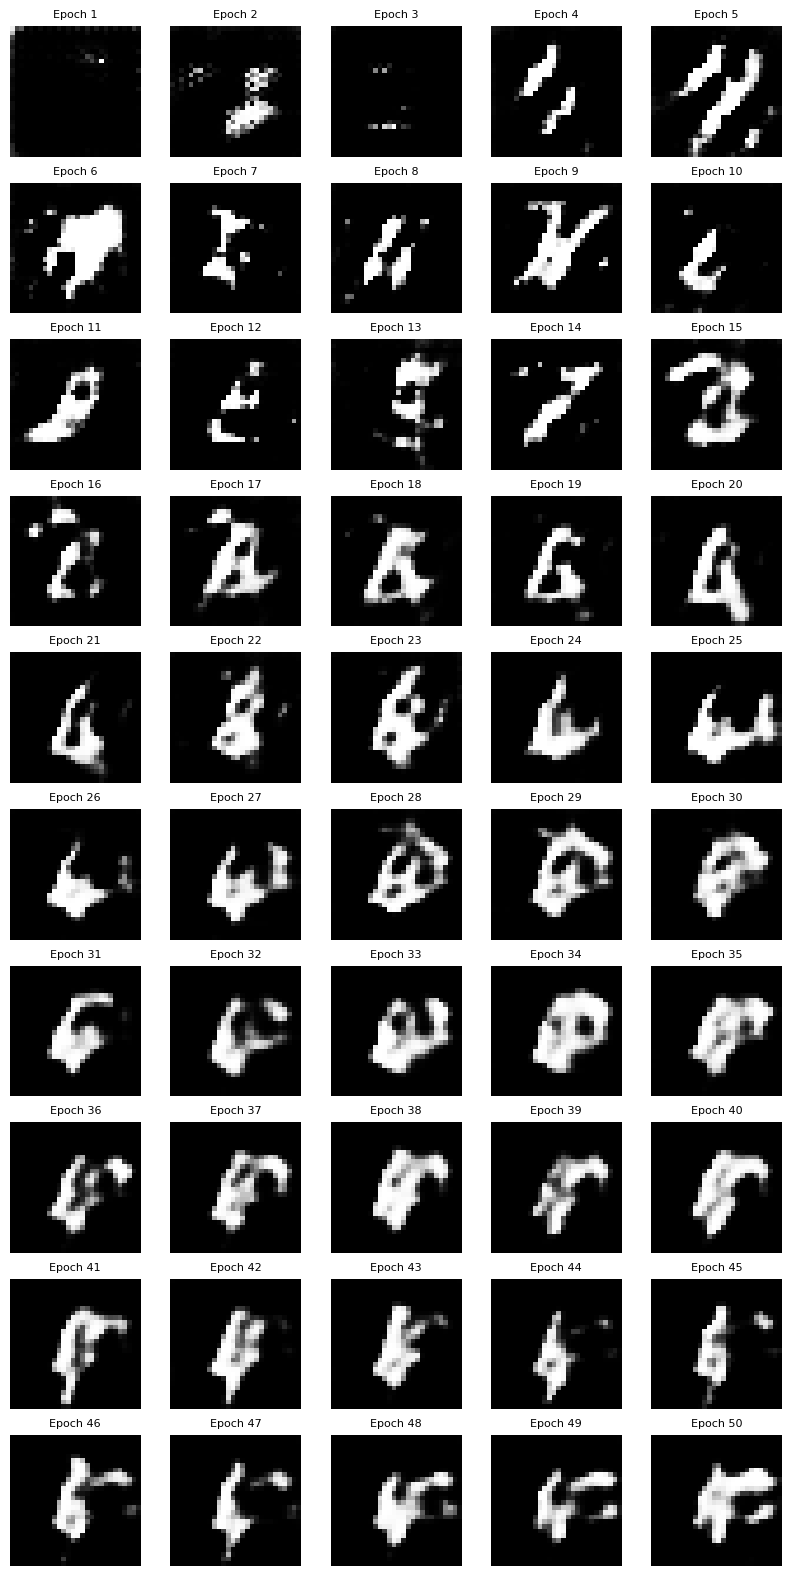

In [ ]:
train(train_dataset, EPOCHS, 5, 10)